# EDA

In [1]:
# ruff: noqa
%reload_ext autoreload
%autoreload 2

# Standard library
import os
import json

# External libraries
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rootutils
import hydra

# Local imports
import ml_project_2_mlp.utils as utils

/Users/jonas-mika/Library/Caches/pypoetry/virtualenvs/ml-project-2-mlp-a6NSXBdT-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reinitialize hydra on every run
hydra.core.global_hydra.GlobalHydra.instance().clear()
h = hydra.initialize(config_path="../conf", job_name="eda", version_base=None)

# Setup root environment
root_path = rootutils.setup_root(".")
rootutils.set_root(
    path=root_path,
    project_root_env_var=True,
)

In [3]:
# Global paths
ROOT_DIR = root_path
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

In [4]:
# Costs per token based on https://openai.com/pricing
GPT4_COST_PER_INP_TOKEN = 0.00001
GPT4_COST_PER_OUT_TOKEN = 0.00003
GPT3_5_COST_PER_INP_TOKEN = 0.000001
GPT3_5_COST_PER_OUT_TOKEN = 0.000002

In [5]:
rename_dict = {
    "human": "Human",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "context1": "Context 1",
    "context2": "Context 2",
    "context3": "Context 3",
    "zeroshot": "0-shot",
    "oneshot": "1-shot",
    "f1": "Macro F1",
    "acc": "Acc",
    "precision": "Precision",
    "recall": "Recall",
    "lpp": "Labels Per Page",
}

def get_labeler_name(name: str):
    return " + ".join([rename_dict.get(n, n) for n in name.split("-")])

def get_metric_name(name: str):
    if "/" in name:
        split, metric = name.split("/")
        return f"{rename_dict.get(split, split)} {rename_dict.get(metric, metric)}"
    else:
        return rename_dict.get(name, name)

In [6]:
style = "dark"
palette = "inferno"
sns.set_style(style)
sns.set_palette(palette)

In [7]:
def get_num_features(feat, data):
    return len([w[feat] for w in data.values() if w[feat] is not None and w[feat] != []])

## Websites

---

There are three copora of websites in this dataset:

* `original`: 770 websites from the crowdsourced dataset from the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786)
* `gpt`: 250 common websites obtained by prompting GPT-4 (see [Prompts](https://chat.openai.com/share/a76c8b9b-a659-4b15-9ab0-d94af4733d58))
* `curlie`: A filtered version of the [curlie](https://curlie.org) dataset, containing ~1M websites

For each website, the repository contains a CSV file at the path `data/raw/<corpus>.csv` with the two columns - `wid` and `url`. The `wid` is a unique identifier for the website, and the `url` is the URL of the website.

In [8]:
# Initialise Config
original_cfg = hydra.compose(config_name="eda", overrides=["data=original"])
gpt_cfg = hydra.compose(config_name="eda", overrides=["data=gpt"])
curlie_cfg = hydra.compose(config_name="eda", overrides=["data=curlie"])

In [9]:
# Load categories
path = os.path.join(root_path, "data", "meta", "categories.json")
with open(path) as f:
    categories = json.load(f)

print(f"Classifying in {len(categories)} categories: {', '.join(categories)}")

Classifying in 14 categories: Arts, Business, Computers, Games, Health, Home, Kids_and_Teens, News, Recreation, Reference, Science, Shopping, Society, Sports


We will continue by exploring each of our datasets, we will store info about each of the indivudal datasets in a list of dictionaries.

In [10]:
webinfo = []

### Original Data

This is the data that was used to test the model in the original paper. 

In [11]:
# Raw data
original_data = hydra.utils.instantiate(original_cfg.data)

raw_data = original_data.get_raw_data()
processed_data = original_data.get_processed_data()
embedded_data = original_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 840


,wid,url
0,1161124,www.pointlesssites.com
1,1081241,www.connecticutplastics.com
2,1162420,99percentinvisible.org
3,1146040,www.medicaid.gov
4,1117243,www.graalonline.com


In [12]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: PointlessSites.com  Fun Things To Do When You're Bored
Description: Are you bored? Want something fun to do? Check out these funny websites, pointless facts and stupid pictures brought to you by Pointless Sites!
Keywords: ['Pointless', 'Sites', 'portal,', 'useless', 'pointlessness']
Tags: ['description', 'viewport', 'author', 'keywords', 'robots', 'copyright']
Domain: pointlesssites
TLD: com


In [13]:
# Setup info dict for original
original_info = dict()

# Save these into a dict
original_info["n"] = len(processed_data)
original_info["tld"] = get_num_features("tld", processed_data) / original_info["n"] * 100
original_info["domain"] = get_num_features("domain", processed_data) / original_info["n"] * 100
original_info["tags"] = get_num_features("metatags", processed_data) / original_info["n"] * 100
original_info["titles"] = get_num_features("title", processed_data) / original_info["n"] * 100
original_info["descriptions"] = get_num_features("description", processed_data) / original_info["n"] * 100
original_info["keywords"] = get_num_features("keywords", processed_data) / original_info["n"] * 100
original_info["links"] = get_num_features("links", processed_data) / original_info["n"] * 100
original_info["sentences"] = get_num_features("sentences", processed_data) / original_info["n"] * 100

for k, v in original_info.items():
    if k != "n":
        print(f"ℹ️ Percentage of sites with {k}: {v:.2f}%")


ℹ️ Percentage of sites with tld: 100.00%
ℹ️ Percentage of sites with domain: 100.00%
ℹ️ Percentage of sites with tags: 93.69%
ℹ️ Percentage of sites with titles: 98.42%
ℹ️ Percentage of sites with descriptions: 54.93%
ℹ️ Percentage of sites with keywords: 19.58%
ℹ️ Percentage of sites with links: 89.88%
ℹ️ Percentage of sites with sentences: 99.08%


### GPT

In [14]:
# Raw data
gpt_data = hydra.utils.instantiate(gpt_cfg.data)

raw_data = gpt_data.get_raw_data()
processed_data = gpt_data.get_processed_data()
embedded_jdata = gpt_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 250


,wid,url
0,0,google.com
1,1,facebook.com
2,2,youtube.com
3,3,amazon.com
4,4,wikipedia.org


In [15]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: Google
Description: None
Keywords: []
Tags: ['referrer']
Domain: google
TLD: com


In [16]:
gpt_info = dict()

# Save these into a dict
gpt_info["n"] = len(processed_data)
gpt_info["tld"] = get_num_features("tld", processed_data) / gpt_info["n"] * 100
gpt_info["domain"] = get_num_features("domain", processed_data) / gpt_info["n"] * 100
gpt_info["tags"] = get_num_features("metatags", processed_data) / gpt_info["n"] * 100
gpt_info["titles"] = get_num_features("title", processed_data) /  gpt_info["n"] * 100
gpt_info["descriptions"] = get_num_features("description", processed_data) / gpt_info["n"] * 100
gpt_info["keywords"] = get_num_features("keywords", processed_data) / gpt_info["n"] * 100
gpt_info["links"] = get_num_features("links", processed_data) / gpt_info["n"] * 100
gpt_info["sentences"] = get_num_features("sentences", processed_data) / gpt_info["n"] * 100

for k, v in gpt_info.items():
    if k != "n":
        print(f"ℹ️ Percentage of sites with {k}: {v:.2f}%")

ℹ️ Percentage of sites with tld: 100.00%
ℹ️ Percentage of sites with domain: 100.00%
ℹ️ Percentage of sites with tags: 98.17%
ℹ️ Percentage of sites with titles: 96.35%
ℹ️ Percentage of sites with descriptions: 86.30%
ℹ️ Percentage of sites with keywords: 22.37%
ℹ️ Percentage of sites with links: 85.84%
ℹ️ Percentage of sites with sentences: 96.35%


### Curlie

In [17]:
# Raw data
curlie_data = hydra.utils.instantiate(curlie_cfg.data)

raw_data = curlie_data.get_raw_data()
processed_data = curlie_data.get_processed_data()
embedded_jdata = curlie_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 10000


,wid,url
0,917678,www.winandsoft.fr
1,443072,gaude-ag.de
2,728091,www.housing.ucsb.edu
3,132596,www.daccad.nl
4,464355,www.rockhall.com


In [18]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: Logiciel bibliothèque, médiathèque, vidéothèque.
Description: Logiciel bibliothèque  logiciel permettant le catalogage de tous types de documents ou supports pour les besoins d'une bibliothèque. Le logiciel bibliothèque vous garantit la gestion documentaire la plus efficace (livres, cartes, manuscrits, incunables, etc.).
Keywords: ['logiciel', 'bibliotheque,logiciel', 'mediatheque,logiciel', 'gestion', 'bibliotheque,logiciel', 'gestion', 'mediatheque,logiciel,bibliotheque,mediatheque']
Tags: ['description', 'copyright', 'robots', 'keywords', 'author']
Domain: winandsoft
TLD: fr


In [19]:
curlie_info = dict()

# Save these into a dict
curlie_info["n"] = len(processed_data)
curlie_info["tld"] = get_num_features("tld", processed_data) / curlie_info["n"] * 100
curlie_info["domain"] = get_num_features("domain", processed_data) / curlie_info["n"] * 100
curlie_info["tags"] = get_num_features("metatags", processed_data) / curlie_info["n"] * 100
curlie_info["titles"] = get_num_features("title", processed_data) / curlie_info["n"] * 100
curlie_info["descriptions"] = get_num_features("description", processed_data) / curlie_info["n"] * 100
curlie_info["keywords"] = get_num_features("keywords", processed_data) / curlie_info["n"] * 100
curlie_info["links"] = get_num_features("links", processed_data) / curlie_info["n"] * 100
curlie_info["sentences"] = get_num_features("sentences", processed_data) / curlie_info["n"] * 100

for k, v in curlie_info.items():
    if k != "n":
        print(f"ℹ️ Percentage of sites with {k}: {v:.2f}%")

ℹ️ Percentage of sites with tld: 100.00%
ℹ️ Percentage of sites with domain: 100.00%
ℹ️ Percentage of sites with tags: 95.47%
ℹ️ Percentage of sites with titles: 98.28%
ℹ️ Percentage of sites with descriptions: 62.95%
ℹ️ Percentage of sites with keywords: 27.29%
ℹ️ Percentage of sites with links: 91.62%
ℹ️ Percentage of sites with sentences: 99.03%


### LaTeX Table

In [20]:
# Put the data info into a dataframe
df = pd.DataFrame([original_info, gpt_info, curlie_info], index=["Original", "GPT", "Curlie"]).round(2)

# Change all columns names to include (%)
df.columns = [f"{c} (%)" if c != "n" else c for c in df.columns]

df = df.T

# Save the dataframe to a latex table
position = "h!"
save_path = os.path.join(root_path, "report", "tables", "feature_information.tex")
latex = df.to_latex(
    caption="Percentage of websites with each feature accross our datasets.", 
    label="tab:feature_information",
    escape=True,
    float_format="%.2f",
    position=position
)

# Add \centering right after \begin{table}
latex = latex.replace("\\begin{table}" + f"[{position}]", "\\begin{table}" + f"[{position}]" + "\n\\centering")
with open(save_path, "w") as f:
    f.write(latex)

df.head()

,Original,GPT,Curlie
n,761.00,219.00,9190.00
tld (%),100.00,100.00,100.00
domain (%),100.00,100.00,100.00
tags (%),93.69,98.17,95.47
titles (%),98.42,96.35,98.28


## Labelers

---

There are multiple GPT labeler instances that can be used to label the data. The labelers are defined in the labelers module and are identified by a `context`, `model` and `fewshow` parameter. The `context` parameter defines the context that is used to prompt the model. The `model` parameter defines the model that is used to generate the labels. The `fewshot` parameter defines whether the model is trained in a few-shot manner or not.

| Parameter | Variants | Description |
| --- | --- | ---  |
| `context` | `context1` | Uses the `tld`, `domain` and `metatags` as context |
| | `context2` | Uses the `tld`, `domain`, `metatags`, `links` and `text` as context |
| | `context3` | Uses the `tld`, `domain`, `metatags`, `links`, `text` and `images` as context |
| `model` | `gpt3.5` | Uses GPT-3.5 (`gpt-3.5-turbo-1106`) |
| | `gpt4` | Uses GPT-4 (`gpt-4-1106-preview`) |
| `fewshot` | `fewshot` | Injects an example website and label into the system prompt |
| | `zeroshot` | Does not inject any example website or label into the system prompt |

We are considering all contexts and few-shot settings for the GPT-3.5 model, but only the `context2` for the GPT-4 model. Additionally, we have the `human` labeler which simply loads the annotatations for the `original` dataset from the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786).

In [21]:
# Initialise configuration for all labelers
gpt_labeler_names = ["gpt3.5-zeroshot-context1", "gpt3.5-oneshot-context1", "gpt3.5-zeroshot-context2", "gpt3.5-oneshot-context2", "gpt3.5-zeroshot-context3", "gpt3.5-oneshot-context3", "gpt4-zeroshot-context2", "gpt4-oneshot-context2"] 

gpt_labelers_cfg = {labeler: hydra.compose(config_name="eda", overrides=[f"labeler={labeler}"]) for labeler in gpt_labeler_names}

In [22]:
# Instantiate data
original_data_cfg = hydra.compose(config_name="eda", overrides=["data=original"])
original_data = hydra.utils.instantiate(original_data_cfg.data)

In [23]:
# Instantiate labelers
gpt_labelers = {labeler: hydra.utils.instantiate(cfg.labeler, data=original_data) for labeler, cfg in gpt_labelers_cfg.items()}

In [24]:
# Instatntiate labelers dataframe
def get_info(labeler):
    return {
        "model": labeler.model,
        "context": labeler.name.split("-")[-1],
        "shot": labeler.fewshot,
    }

labeler_info = pd.DataFrame(
    [get_info(labeler) for labeler in gpt_labelers.values()],
    index=[get_labeler_name(name) for name in gpt_labelers.keys()])
labeler_info

,model,context,shot
GPT-3.5 + 0-shot + Context 1,gpt-3.5-turbo-1106,context1,False
GPT-3.5 + 1-shot + Context 1,gpt-3.5-turbo-1106,context1,True
GPT-3.5 + 0-shot + Context 2,gpt-3.5-turbo-1106,context2,False
GPT-3.5 + 1-shot + Context 2,gpt-3.5-turbo-1106,context2,True
GPT-3.5 + 0-shot + Context 3,gpt-3.5-turbo-1106,context3,False
GPT-3.5 + 1-shot + Context 3,gpt-3.5-turbo-1106,context3,True
GPT-4 + 0-shot + Context 2,gpt-4-1106-preview,context2,False
GPT-4 + 1-shot + Context 2,gpt-4-1106-preview,context2,True


Let's verify that the labelers are working as expected by checking the number of labeled webpages.

In [25]:
num_processed_websites = len(original_data.get_processed_data())

print(f"ℹ️ Number of processed websites: {num_processed_websites}")
for name, labeler in gpt_labelers.items():
    num_labels = len(labeler.get_labels())
    print(f"ℹ️ Number of {name} labels: {num_labels}")

ℹ️ Number of processed websites: 761
ℹ️ Number of gpt3.5-zeroshot-context1 labels: 761
ℹ️ Number of gpt3.5-oneshot-context1 labels: 761
ℹ️ Number of gpt3.5-zeroshot-context2 labels: 761
ℹ️ Number of gpt3.5-oneshot-context2 labels: 761
ℹ️ Number of gpt3.5-zeroshot-context3 labels: 761
ℹ️ Number of gpt3.5-oneshot-context3 labels: 761
ℹ️ Number of gpt4-zeroshot-context2 labels: 761
ℹ️ Number of gpt4-oneshot-context2 labels: 761


### Labeling statistics

Let's investigate some statistics about the labelers. We will compute:

* The average number of labels per website
* The number of valid labels
* The number of invalid labels
* The average time taken to label a website
* The average number of prompt and completion tokens used to label a website
* The estimated cost of labeling the entire dataset

In [26]:
def get_statistics(labeler):
    statistics = {"valid": 0, "invalid": 0, "lpp": [], "durations": [], "prompt_tokens": [], "completion_tokens": []}
    for website in labeler.get_labels().values():
        if not website["is_valid"]:
            statistics["invalid"] += 1
            continue

        statistics["valid"] += 1
        statistics["lpp"].append(sum(website["labels"]))
        statistics["durations"].append(website["duration"])
        statistics["prompt_tokens"].append(website["prompt_tokens"])
        statistics["completion_tokens"].append(website["completion_tokens"])

    lpps = np.array(statistics["lpp"])
    durations = np.array(statistics["durations"])
    prompt_tokens = np.array(statistics["prompt_tokens"])
    completion_tokens = np.array(statistics["completion_tokens"])

    statistics["lpp"] = f"{lpps.mean():.2f} ± {lpps.std():.2f}"
    statistics["durations"] = f"{durations.mean():.2f} ± {durations.std():.2f}"
    statistics["prompt_tokens"] = f"{prompt_tokens.mean():.2f} ± {prompt_tokens.std():.2f}"
    statistics["completion_tokens"] = f"{completion_tokens.mean():.2f} ± {completion_tokens.std():.2f}"
    
    # Compute estimated cost
    model = labeler.model
    COST_PER_INP_TOKEN = GPT4_COST_PER_INP_TOKEN if "gpt4" in model else GPT3_5_COST_PER_INP_TOKEN
    COST_PER_OUT_TOKEN = GPT4_COST_PER_OUT_TOKEN if "gpt4" in model else GPT3_5_COST_PER_OUT_TOKEN

    statistics["estimated_cost"] = f"{(prompt_tokens.sum() * COST_PER_INP_TOKEN + completion_tokens.sum() * COST_PER_OUT_TOKEN):.2f}"

    return statistics

In [27]:
labeler_statistics = pd.DataFrame(
    [get_statistics(labeler) for labeler in gpt_labelers.values()], 
    index=[get_labeler_name(name) for name in gpt_labelers.keys()]) 
labeler_statistics

,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost
GPT-3.5 + 0-shot + Context 1,761,0,0.39 ± 0.61,3.51 ± 5.87,148.80 ± 18.14,107.54 ± 2.75,0.28
GPT-3.5 + 1-shot + Context 1,761,0,0.91 ± 0.95,2.99 ± 4.61,292.80 ± 18.14,92.71 ± 3.31,0.36
GPT-3.5 + 0-shot + Context 2,761,0,1.39 ± 0.98,3.63 ± 6.79,206.30 ± 60.33,107.90 ± 1.48,0.32
GPT-3.5 + 1-shot + Context 2,761,0,1.68 ± 1.15,2.85 ± 0.42,448.30 ± 60.33,93.11 ± 4.06,0.48
GPT-3.5 + 0-shot + Context 3,761,0,1.57 ± 1.08,3.27 ± 0.69,350.13 ± 124.30,108.00 ± 0.06,0.43
GPT-3.5 + 1-shot + Context 3,761,0,1.85 ± 1.24,3.07 ± 4.31,615.13 ± 124.30,94.92 ± 6.18,0.61
GPT-4 + 0-shot + Context 2,761,0,2.16 ± 1.03,5.73 ± 1.98,206.30 ± 60.33,106.61 ± 7.14,0.32
GPT-4 + 1-shot + Context 2,761,0,2.49 ± 1.28,5.16 ± 2.35,448.30 ± 60.33,92.29 ± 2.52,0.48


### Class Distribution

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/original-label-distribution.pdf


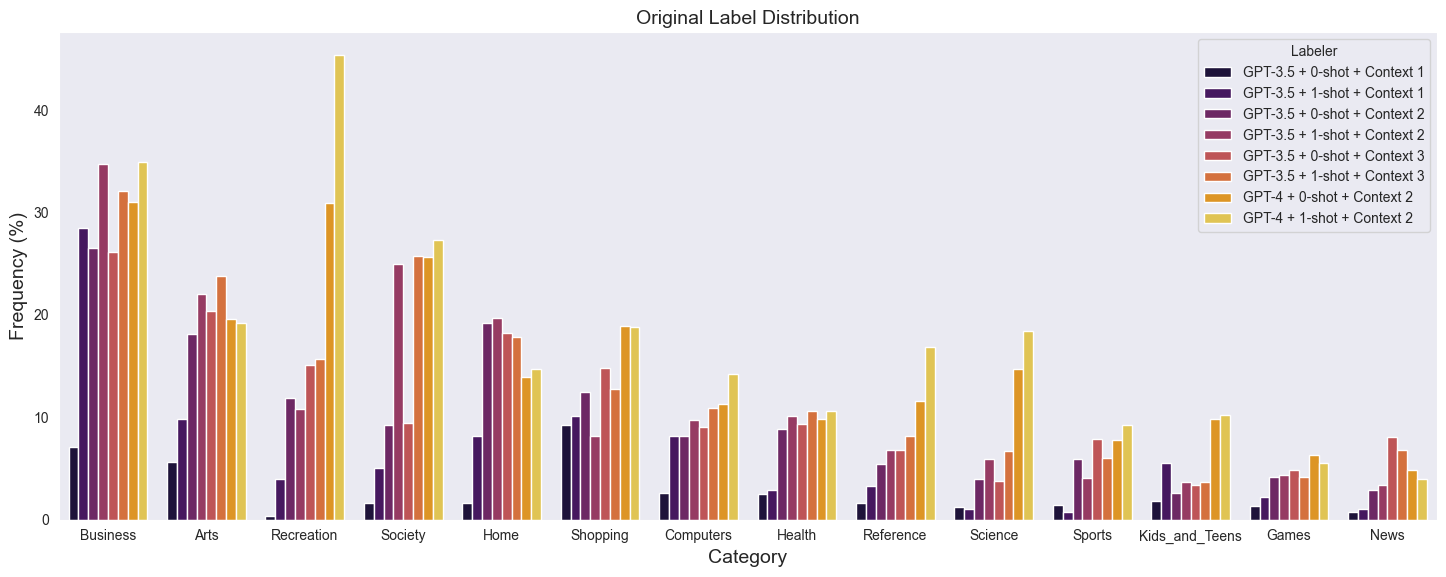

In [28]:
def get_label_dist(labelers):
    rows = []
    for name, class_dist in {name: labeler.get_class_dist(normalise=True) for name, labeler in labelers.items()}.items():
        for category, freq in class_dist.items():
            rows.append({"labeler": get_labeler_name(name), "category": category, "freq": 100 * freq})
    return pd.DataFrame(rows)

label_dist = get_label_dist(gpt_labelers)
fig, ax = plt.subplots(figsize=(15, 6))
fig.tight_layout(pad=3.0)
sns.barplot(
    label_dist,
    x="category",
    y="freq",
    hue="labeler",
    palette=palette,
    order=label_dist.groupby("category").sum().sort_values("freq", ascending=False).index,
    ax=ax
)
ax.get_legend().set_title("Labeler")
ax.set_xlabel("Category", fontsize=14)
ax.set_ylabel("Frequency (%)", fontsize=14)
ax.set_title("Original Label Distribution", fontsize=14)

path = os.path.join(FIGURE_DIR, "original-label-distribution.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")

### Labeling Quality

The goal of all GPT labelers is to replicate the ground truth labels provide by the human annotators as closely as possible. As we only have human annotations for the original dataset, we can only evaluate the labelers on this dataset.

In [29]:
# Instatiate human labeler
original_cfg = hydra.compose(config_name="eda", overrides=["data=original"])
human_labeler_cfg = hydra.compose(config_name="eda", overrides=["labeler=human", "data=original"])
original_data = hydra.utils.instantiate(original_cfg.data)
human_labeler = hydra.utils.instantiate(human_labeler_cfg.labeler, data=original_data)

In [30]:
def match_labels(labeler1, labeler2, subset = None):
    labels1 = labeler1.get_labels()
    labels2 = labeler2.get_labels()
    wid1 = set(labels1.keys())
    wid2 = set(labels2.keys())
    matched_wid = wid1 & wid2
    if subset:
        matched_wid = matched_wid & subset

    labels1 = np.array([labels1[wid]["labels"] for wid in matched_wid])
    labels2 = np.array([labels2[wid]["labels"] for wid in matched_wid])

    return labels1, labels2

In [31]:
def get_labeler_perf(labeler):
    labels1, labels2 = match_labels(human_labeler, labeler)

    acc = accuracy_score(labels1.flatten(), labels2.flatten())
    subset_acc = accuracy_score(labels1, labels2)
    macro_f1 = f1_score(labels1, labels2, average="macro")
    micro_f1 = f1_score(labels1, labels2, average="micro")
    weighted_f1 = f1_score(labels1, labels2, average="weighted")
    macro_precision = precision_score(labels1, labels2, average="macro", zero_division=0)
    micro_precision = precision_score(labels1, labels2, average="micro", zero_division=0)
    macro_recall = recall_score(labels1, labels2, average="macro", zero_division=0)
    micro_recall = recall_score(labels1, labels2, average="micro", zero_division=0)

    return {
        "name": get_labeler_name(name),
        "acc": acc,
        "subset_acc": subset_acc,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "micro_precision": micro_precision,
        "macro_recall": macro_recall,
        "micro_recall": micro_recall,
    }

In [32]:
labeler_perf = pd.DataFrame([get_labeler_perf(labeler) for labeler in gpt_labelers.values()], 
                            index=[get_labeler_name(name) for name in gpt_labelers.keys()])
labeler_perf

,name,acc,subset_acc,macro_f1,micro_f1,weighted_f1,macro_precision,micro_precision,macro_recall,micro_recall
GPT-3.5 + 0-shot + Context 1,GPT-4 + 1-shot + Context 2,0.827013,0.085414,0.159570,0.162653,0.155489,0.635233,0.606780,0.097283,0.093914
GPT-3.5 + 1-shot + Context 1,GPT-4 + 1-shot + Context 2,0.826826,0.091984,0.232630,0.289017,0.277751,0.565566,0.544267,0.161507,0.196747
GPT-3.5 + 0-shot + Context 2,GPT-4 + 1-shot + Context 2,0.836306,0.139290,0.375855,0.412003,0.411554,0.562262,0.576415,0.297584,0.320567
GPT-3.5 + 1-shot + Context 2,GPT-4 + 1-shot + Context 2,0.832551,0.127464,0.386863,0.440402,0.440510,0.526652,0.547582,0.320552,0.368311
GPT-3.5 + 0-shot + Context 3,GPT-4 + 1-shot + Context 2,0.828046,0.128778,0.372394,0.409794,0.410367,0.499444,0.530885,0.314836,0.333683
GPT-3.5 + 1-shot + Context 3,GPT-4 + 1-shot + Context 2,0.821476,0.115637,0.377024,0.426071,0.428640,0.464730,0.501420,0.328673,0.370409
GPT-4 + 0-shot + Context 2,GPT-4 + 1-shot + Context 2,0.828515,0.115637,0.453939,0.485497,0.490625,0.499528,0.524012,0.429976,0.452256
GPT-4 + 1-shot + Context 2,GPT-4 + 1-shot + Context 2,0.820255,0.086728,0.459306,0.496450,0.505203,0.484074,0.497628,0.461682,0.495278


### Analysis

In [33]:
# Join with labeling statistics
labelers_df = pd.concat([labeler_info, labeler_statistics, labeler_perf], axis=1)

In [34]:
# Top-k performing labeler
top_k = 5
labelers_df.sort_values("macro_f1", ascending=False).head(top_k)

,model,context,shot,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost,name,acc,subset_acc,macro_f1,micro_f1,weighted_f1,macro_precision,micro_precision,macro_recall,micro_recall
GPT-4 + 1-shot + Context 2,gpt-4-1106-preview,context2,True,761,0,2.49 ± 1.28,5.16 ± 2.35,448.30 ± 60.33,92.29 ± 2.52,0.48,GPT-4 + 1-shot + Context 2,0.820255,0.086728,0.459306,0.496450,0.505203,0.484074,0.497628,0.461682,0.495278
GPT-4 + 0-shot + Context 2,gpt-4-1106-preview,context2,False,761,0,2.16 ± 1.03,5.73 ± 1.98,206.30 ± 60.33,106.61 ± 7.14,0.32,GPT-4 + 1-shot + Context 2,0.828515,0.115637,0.453939,0.485497,0.490625,0.499528,0.524012,0.429976,0.452256
GPT-3.5 + 1-shot + Context 2,gpt-3.5-turbo-1106,context2,True,761,0,1.68 ± 1.15,2.85 ± 0.42,448.30 ± 60.33,93.11 ± 4.06,0.48,GPT-4 + 1-shot + Context 2,0.832551,0.127464,0.386863,0.440402,0.440510,0.526652,0.547582,0.320552,0.368311
GPT-3.5 + 1-shot + Context 3,gpt-3.5-turbo-1106,context3,True,761,0,1.85 ± 1.24,3.07 ± 4.31,615.13 ± 124.30,94.92 ± 6.18,0.61,GPT-4 + 1-shot + Context 2,0.821476,0.115637,0.377024,0.426071,0.428640,0.464730,0.501420,0.328673,0.370409
GPT-3.5 + 0-shot + Context 2,gpt-3.5-turbo-1106,context2,False,761,0,1.39 ± 0.98,3.63 ± 6.79,206.30 ± 60.33,107.90 ± 1.48,0.32,GPT-4 + 1-shot + Context 2,0.836306,0.139290,0.375855,0.412003,0.411554,0.562262,0.576415,0.297584,0.320567


✅ Plotted labeler quality as function of model, context and shot


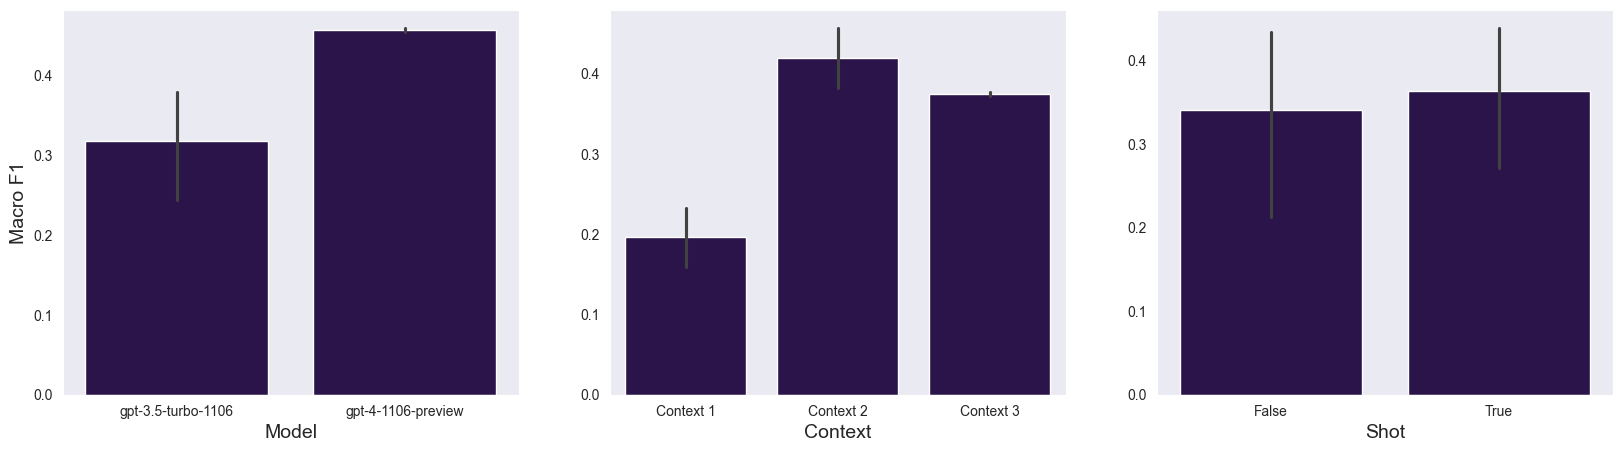

In [35]:
# Univariate performance
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
xs = ["model", "context", "shot"]

for ax, x in zip(axs, xs):
    sns.barplot(
        data=labelers_df,
        x=x,
        y="macro_f1",
        ax=ax
    )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([rename_dict.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])
    ax.set_xlabel(x.capitalize(), fontsize=14)
    ax.set_ylabel("")

axs[0].set_ylabel("Macro F1", fontsize=14)

print(f"✅ Plotted labeler quality as function of model, context and shot")

✅ Plotted figure.


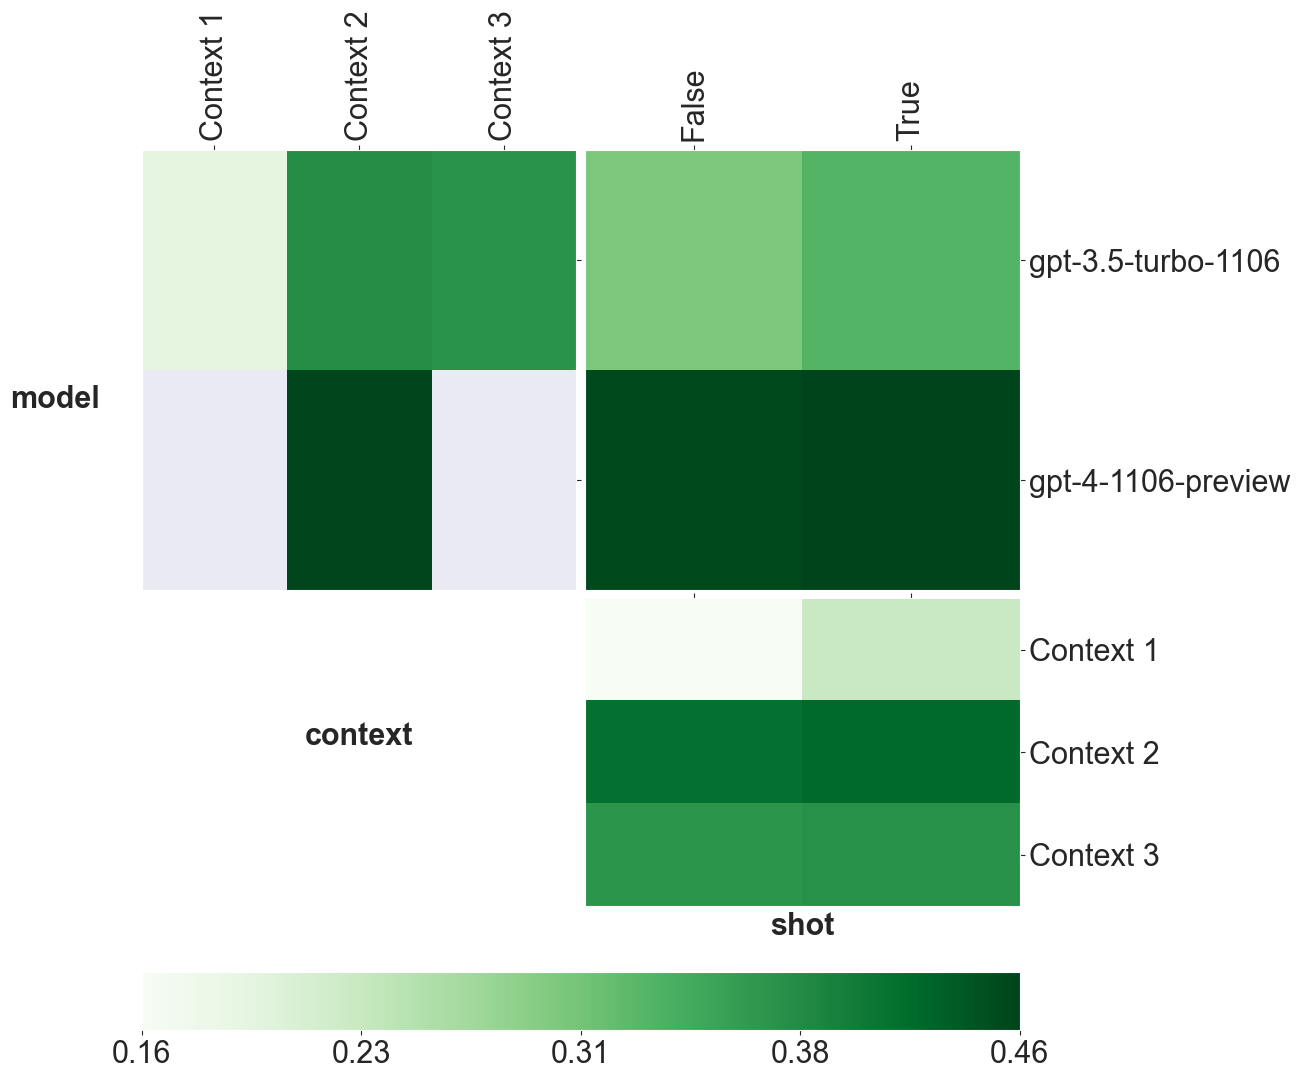

In [36]:
# Labeler parameters
params = ["model", "context", "shot"]

fig = utils.grid(labelers_df, params, metric="mean", cmap="Greens", figsize=(10, 10), rename_dict=rename_dict) 
print(f"✅ Plotted figure.")

### Curlie

In this section we explore the labels of the `curlie-1000` that we relabel with the most promising GPT labelers given the label quality and cost of labeling as shown in the section above.

In [37]:
# Initialise data and labeler config
curlie_cfg = hydra.compose(config_name="eda", overrides=["data=curlie"])
curlie_labeler_names = ["gpt3.5-oneshot-context2"]
curlie_labeler_cfg = {name: hydra.compose(config_name="eda", overrides=[f"labeler={name}"]) for name in curlie_labeler_names}

In [38]:
# Instantiate data
curlie_data = hydra.utils.instantiate(curlie_cfg.data)
curlie_labeler = {name: hydra.utils.instantiate(curlie_labeler.labeler, data=curlie_data) for name, curlie_labeler in curlie_labeler_cfg.items()}
print(f"✅ Initialised {len(curlie_labeler)} labeler(s).")

✅ Initialised 1 labeler(s).


We expect that the LPP will be higher as the labelers have learned to replicate the human labels.

In [39]:
values = [get_statistics(labeler) for labeler in curlie_labeler.values()]
index = [get_labeler_name(name) for name in curlie_labeler.keys()]
labeler_statistics = pd.DataFrame(values, index=index)
labeler_statistics

,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost
GPT-3.5 + 1-shot + Context 2,9190,0,1.60 ± 1.08,2.09 ± 1.04,470.16 ± 87.36,92.99 ± 3.85,6.03


Let's first look at the distribution of labels for each category.

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/curlie-label-distribution.pdf


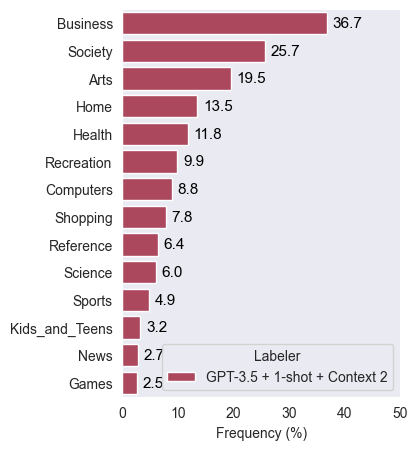

In [40]:
# Plot label distribution
label_dist = get_label_dist(curlie_labeler)
fig, ax = plt.subplots(figsize=(4, 5))
fig.tight_layout(pad=3.0)
sns.barplot(
    label_dist,
    x="freq",
    y="category",
    hue="labeler",
    palette="inferno",
    order=label_dist.groupby("category").sum().sort_values("freq", ascending=False).index,
    ax=ax
)
ax.get_legend().set_title("Labeler")
ax.set_xlabel("Frequency (%)")
ax.set_ylabel("")

# To each bar assign the corresponding percentage
for i, v in enumerate(label_dist.groupby("category").sum().sort_values("freq", ascending=False)["freq"]):
    ax.text(v + 1, i, f"{v:.1f}", color="black", va="center", fontsize=11)

ax.set_xlim(0, 50)

path = os.path.join(FIGURE_DIR, "curlie-label-distribution.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")